In [8]:
# Path
import os, sys
os.chdir('/home/zwang34/IBL/iblfm_exp/IBL_foundation_model')
sys.path.append('./src')
print(sys.path)

from utils.eval_utils import load_model_data_local, co_smoothing_eval, behavior_probe_eval
import numpy as np
import matplotlib.pyplot as plt

['/home/zwang34/miniconda3/envs/ibl-fm/lib/python310.zip', '/home/zwang34/miniconda3/envs/ibl-fm/lib/python3.10', '/home/zwang34/miniconda3/envs/ibl-fm/lib/python3.10/lib-dynload', '', '/home/zwang34/miniconda3/envs/ibl-fm/lib/python3.10/site-packages', './src', '/scratch/zwang34/job_33534697/tmporyr1y7j', './src']


In [82]:
# Args
eid = '746d1902-fa59-4cab-b0aa-013be36060d5'
unaligned_training = True

# Learnable PE

In [83]:
model_path = 'model_{}_method_{}_mask_{}_ratio_{}_ual_training_{}_PE_{}_{}'.format(
    'NDT1',
    'ssl',
    'neuron',
    0.3,
    unaligned_training,
    'learnable',
    'common',
)
## Load Model (borrowed from model eval pipeline)
log_dir = os.path.join(
    '/expanse/lustre/scratch/zwang34/temp_project/random_exp',
    eid, 
    'train',
    model_path,
)
    
    

configs = {
    'model_config': 'src/configs/ndt1_v0/ndt1_v0.yaml',
    'model_path': os.path.join(log_dir, 'best'),
    'trainer_config': 'src/configs/ndt1_v0/trainer_ndt1_v0.yaml',
    'seed': 42,
    'mask_mode': 'neuron',
    'eid': eid
}
    
model, accelerator, dataset, dataloader = load_model_data_local(**configs)
num_neurons = len(dataset[0]['cluster_uuids'])

seed set to 42


Generating test split: 100%|██████████| 130/130 [00:00<00:00, 664.22 examples/s]


number of neurons: 1337
len(dataset): 130


Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


spike data shape:(130, 100, 1337)
--------------------------------------------------
Evaluating Configuration
--------------------------------------------------
Load the following model from /expanse/lustre/scratch/zwang34/temp_project/random_exp/746d1902-fa59-4cab-b0aa-013be36060d5/train/model_NDT1_method_ssl_mask_neuron_ratio_0.3_ual_training_True_PE_learnable_common/best
NDT1(
  (encoder): NeuralEncoder(
    (masker): Masker()
    (norm_and_noise): NormAndNoise()
    (embedder): NeuralEmbeddingLayer(
      (embed_spikes): Linear(in_features=1337, out_features=2674, bias=True)
      (projection): Linear(in_features=2674, out_features=512, bias=True)
      (act): Softsign()
      (embed_pos): Embedding(100, 512)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (layers): ModuleList(
      (0-4): 5 x NeuralEncoderLayer(
        (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (attn): NeuralAttention(
          (query): Linear(in_features=512, out_features=512

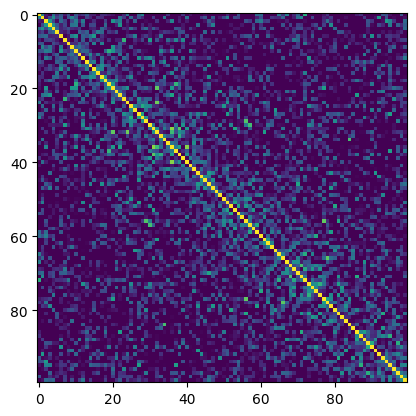

In [84]:
# Similarity Matrix (Cosine)

def cosine_similarity(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

PE = model.encoder.embedder.embed_pos.weight.detach().cpu().numpy()
sim_m = np.zeros((100, 100))
for pos1 in range(100):
    for pos2 in range(100):
       sim_m[pos1, pos2] = cosine_similarity(PE[pos1, :], PE[pos2, :])

plt.imshow(sim_m, cmap='viridis', vmax=.2, vmin=0, interpolation='none')

/home/zwang34/miniconda3/envs/ibl-fm/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


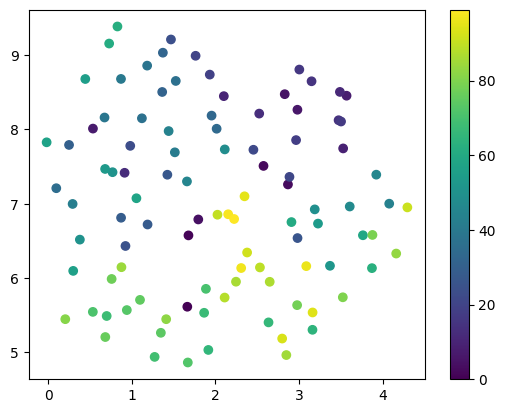

In [85]:
## UMAP
import umap
umap_reducer = umap.UMAP(n_components=2, metric='cosine', random_state=42)
PE_2d = umap_reducer.fit_transform(PE)
plt.scatter(PE_2d[:, 0], PE_2d[:, 1], c=np.arange(PE_2d.shape[0]), cmap='viridis')
plt.colorbar()

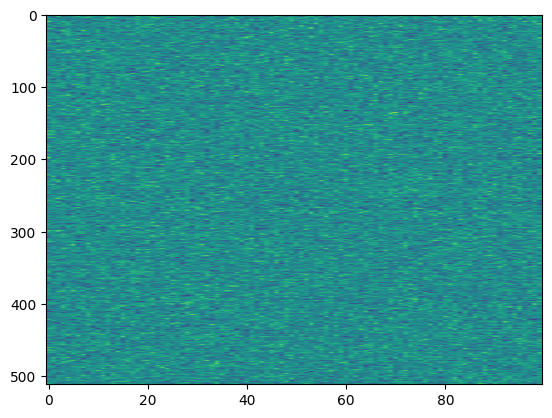

In [86]:
## Direct Visualize
plt.imshow(PE.T, aspect='auto')

# Sinusoidal PE & RoPE

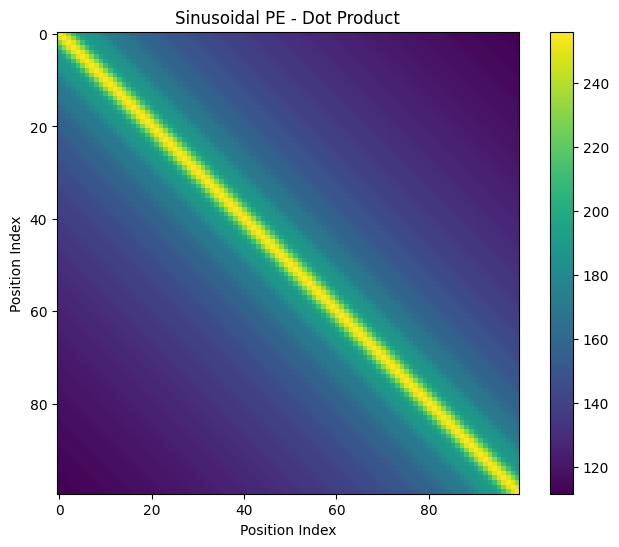

In [75]:
import numpy as np
import matplotlib.pyplot as plt

def sinusoidal_pe(seq_len, dim):
    pe = np.zeros((seq_len, dim))
    position = np.arange(0, seq_len).reshape(-1, 1)
    div_term = np.exp(np.arange(0, dim, 2) * -(np.log(10000.0) / dim))
    pe[:, 0::2] = np.sin(position * div_term)
    pe[:, 1::2] = np.cos(position * div_term)
    return pe

def plot_dot_product(pe, title):
    dot_product_matrix = np.dot(pe, pe.T)
    plt.figure(figsize=(8, 6))
    plt.imshow(dot_product_matrix, cmap='viridis', interpolation='none')
    plt.colorbar()
    plt.title(f'{title} - Dot Product')
    plt.xlabel('Position Index')
    plt.ylabel('Position Index')
    plt.show()

seq_len = 100
dim = 512

sin_pe = sinusoidal_pe(seq_len, dim)

plot_dot_product(sin_pe, 'Sinusoidal PE')

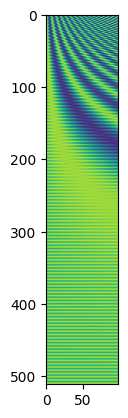

In [73]:
plt.imshow(sin_pe.T)